# Engenharia de Machine Learning [25E1_3]
## Data 26/03/2025


## Para executar somente se utilizar o Google Colab

In [ ]:
# Só precisa ser executado se este notebook for executado no Google Colab
!pip install scikit-learn-extra

## Import das bibliotecas

In [27]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, roc_curve, auc
from sklearn.svm import SVC

from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import dtw

from scipy.signal import correlate

# Carregando os dados

In [28]:
# Carrega os dados brutos, baixados do Kaggle
url = '../data/01_raw/data.csv'

In [29]:
# Carregando os dados
df = pd.read_csv(url)
# variáveis com os campos necessários para os enunciados
# todos os campos 
features_all = ['action_type', 'combined_shot_type', 'game_event_id', 'game_id', 'lat', 'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs', 'season', 'seconds_remaining', 'shot_distance', 'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'team_id', 'team_name', 'game_date', 'matchup', 'opponent', 'shot_id']
features =  ['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance']
target = ['shot_made_flag']

## Removendo campos nulos

In [30]:
# Removendo os campos nulos
df = df.dropna()
# Agora deve mostrar que não há mais campos nulos
df.isna().sum()

action_type           0
combined_shot_type    0
game_event_id         0
game_id               0
lat                   0
loc_x                 0
loc_y                 0
lon                   0
minutes_remaining     0
period                0
playoffs              0
season                0
seconds_remaining     0
shot_distance         0
shot_made_flag        0
shot_type             0
shot_zone_area        0
shot_zone_basic       0
shot_zone_range       0
team_id               0
team_name             0
game_date             0
matchup               0
opponent              0
shot_id               0
dtype: int64

## Criando as bases X e y

In [31]:
# Features Dataset
X = df[features]
# Target Dataset (predição)
y = df[target]

## Criaando estratificador

In [32]:
# Definindo validação cruzada estratificada (10 folds)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

## Criando as bases de dados de treino e teste

In [33]:
# Configurando 80% de treino e 20% para teste
test_size = 0.2

# Random state
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    stratify=y
)

# Reconstruindo os DataFrames completos
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# Modelos com a base toda

## Regressão Logística

In [34]:
# Criando o modelo de Regressão Logística
modelLR_all = LogisticRegression(solver='liblinear', random_state=42)
# Treinando o modelo
modelLR_all.fit(X, y)

LogisticRegression(random_state=42, solver='liblinear')

### Calculando scores

In [35]:
# Acurácia, precisão, recall e f1-score
acc_scores = cross_val_score(modelLR_all, X, y, cv=skf, scoring='accuracy')
precision_scores = cross_val_score(modelLR_all, X, y, cv=skf, scoring='precision')
recall_scores = cross_val_score(modelLR_all, X, y, cv=skf, scoring='recall')
f1_scores = cross_val_score(modelLR_all, X, y, cv=skf, scoring='f1')

print("Resultados (Regressão Logística c/ 10-fold Stratified com validação cruzada):\n")
print(f"i) Acurácia (média ± std)  = {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
print(f"ii) Precisão (média ± std) = {precision_scores.mean():.4f} ± {precision_scores.std():.4f}")
print(f"iii) Recall (média ± std)  = {recall_scores.mean():.4f} ± {recall_scores.std():.4f}")
print(f"iv) F1-score (média ± std) = {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")

Resultados (Regressão Logística c/ 10-fold Stratified com validação cruzada):

i) Acurácia (média ± std)  = 0.5959 ± 0.0101
ii) Precisão (média ± std) = 0.5649 ± 0.0161
iii) Recall (média ± std)  = 0.4113 ± 0.0102
iv) F1-score (média ± std) = 0.4760 ± 0.0119


## Árvore de decisão

### Criando o modelo

In [36]:
# Modelo de Árvore de Decisão
modelDTC_all = DecisionTreeClassifier(random_state=42)
# Treinando o modelo
modelDTC_all.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### Calculando scores

In [37]:
# Acurácia, precisão, recall e f1-score
acc_scores = cross_val_score(modelDTC_all, X, y, cv=skf, scoring='accuracy')
prec_scores = cross_val_score(modelDTC_all, X, y, cv=skf, scoring='precision')
rec_scores = cross_val_score(modelDTC_all, X, y, cv=skf, scoring='recall')
f1_scores = cross_val_score(modelDTC_all, X, y, cv=skf, scoring='f1')

print("Desempenho do modelo (Árvore de Decisão) - Validação Cruzada (10 folds):\n")
print(f"i)   Acurácia (média ± std) =  {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
print(f"ii)  Precisão (média ± std) =  {prec_scores.mean():.4f} ± {prec_scores.std():.4f}")
print(f"iii) Recall (média ± std)   =  {rec_scores.mean():.4f} ± {rec_scores.std():.4f}")
print(f"iv)  F1-score (média ± std) =  {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")

Desempenho do modelo (Árvore de Decisão) - Validação Cruzada (10 folds):

i)   Acurácia (média ± std) =  0.5419 ± 0.0127
ii)  Precisão (média ± std) =  0.4882 ± 0.0124
iii) Recall (média ± std)   =  0.5508 ± 0.0168
iv)  F1-score (média ± std) =  0.5175 ± 0.0132


# Modelos com dados de Treino e Teste

## Regressão Logística

### Criando o modelo

In [38]:
# Criando o modelo de Regressão Logística
modelLR = LogisticRegression(solver='liblinear', random_state=42)
# Treinando o modelo
modelLR.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

### Calculando scores

In [39]:
# Acurácia, precisão, recall e f1-score
acc_scores = cross_val_score(modelLR, X, y, cv=skf, scoring='accuracy')
precision_scores = cross_val_score(modelLR, X, y, cv=skf, scoring='precision')
recall_scores = cross_val_score(modelLR, X, y, cv=skf, scoring='recall')
f1_scores = cross_val_score(modelLR, X, y, cv=skf, scoring='f1')

print("Resultados (Regressão Logística c/ 10-fold Stratified com validação cruzada):\n")
print(f"i) Acurácia (média ± std)  = {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
print(f"ii) Precisão (média ± std) = {precision_scores.mean():.4f} ± {precision_scores.std():.4f}")
print(f"iii) Recall (média ± std)  = {recall_scores.mean():.4f} ± {recall_scores.std():.4f}")
print(f"iv) F1-score (média ± std) = {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")

Resultados (Regressão Logística c/ 10-fold Stratified com validação cruzada):

i) Acurácia (média ± std)  = 0.5959 ± 0.0101
ii) Precisão (média ± std) = 0.5649 ± 0.0161
iii) Recall (média ± std)  = 0.4113 ± 0.0102
iv) F1-score (média ± std) = 0.4760 ± 0.0119


## Árvoce de decisão

### Criando o modelo

In [40]:
# Modelo de Árvore de Decisão
modelDTC = DecisionTreeClassifier(random_state=42)
# Treinando o modelo
modelDTC.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### Calculando scores

In [41]:
# Acurácia, precisão, recall e f1-score
acc_scores = cross_val_score(modelDTC, X, y, cv=skf, scoring='accuracy')
prec_scores = cross_val_score(modelDTC, X, y, cv=skf, scoring='precision')
rec_scores = cross_val_score(modelDTC, X, y, cv=skf, scoring='recall')
f1_scores = cross_val_score(modelDTC, X, y, cv=skf, scoring='f1')

print("Desempenho do modelo (Árvore de Decisão) - Validação Cruzada (10 folds):\n")
print(f"i)   Acurácia (média ± std) =  {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
print(f"ii)  Precisão (média ± std) =  {prec_scores.mean():.4f} ± {prec_scores.std():.4f}")
print(f"iii) Recall (média ± std)   =  {rec_scores.mean():.4f} ± {rec_scores.std():.4f}")
print(f"iv)  F1-score (média ± std) =  {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")

Desempenho do modelo (Árvore de Decisão) - Validação Cruzada (10 folds):

i)   Acurácia (média ± std) =  0.5419 ± 0.0127
ii)  Precisão (média ± std) =  0.4882 ± 0.0124
iii) Recall (média ± std)   =  0.5508 ± 0.0168
iv)  F1-score (média ± std) =  0.5175 ± 0.0132


# Curva ROC

## Com a base toda

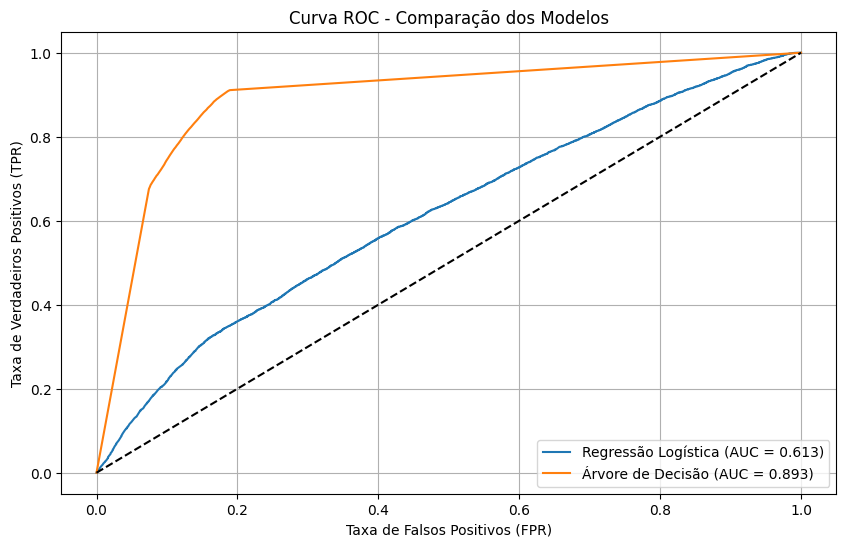


Valores de FPR e TPR para Regressão Logística:
FPR: 0.000, TPR: 0.000
FPR: 0.251, TPR: 0.408
FPR: 0.412, TPR: 0.568
FPR: 0.589, TPR: 0.719
FPR: 0.773, TPR: 0.866

Valores de FPR e TPR para Árvore de Decisão:
FPR: 0.000, TPR: 0.000
FPR: 0.084, TPR: 0.704
FPR: 0.112, TPR: 0.775
FPR: 0.139, TPR: 0.833
FPR: 0.169, TPR: 0.886


In [42]:
# Calcular as probabilidades de predição para cada modelo
y_pred_proba_lr = modelLR_all.predict_proba(X)[:, 1]
y_pred_proba_dtc = modelDTC_all.predict_proba(X)[:, 1]

# Calcular FPR e TPR para cada modelo
fpr_lr, tpr_lr, _ = roc_curve(y, y_pred_proba_lr)
fpr_dtc, tpr_dtc, _ = roc_curve(y, y_pred_proba_dtc)

# Calcular AUC para cada modelo
auc_lr = auc(fpr_lr, tpr_lr)
auc_dtc = auc(fpr_dtc, tpr_dtc)

# Criar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Regressão Logística (AUC = {auc_lr:.3f})')
plt.plot(fpr_dtc, tpr_dtc, label=f'Árvore de Decisão (AUC = {auc_dtc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')  # Linha diagonal
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Comparação dos Modelos')
plt.legend()
plt.grid(True)
plt.show()

# Exibir valores de FPR e TPR para alguns pontos
print("\nValores de FPR e TPR para Regressão Logística:")
for i in range(0, len(fpr_lr), len(fpr_lr)//5):
    print(f"FPR: {fpr_lr[i]:.3f}, TPR: {tpr_lr[i]:.3f}")

print("\nValores de FPR e TPR para Árvore de Decisão:")
for i in range(0, len(fpr_dtc), len(fpr_dtc)//5):
    print(f"FPR: {fpr_dtc[i]:.3f}, TPR: {tpr_dtc[i]:.3f}")

## Com a base de treino e teste

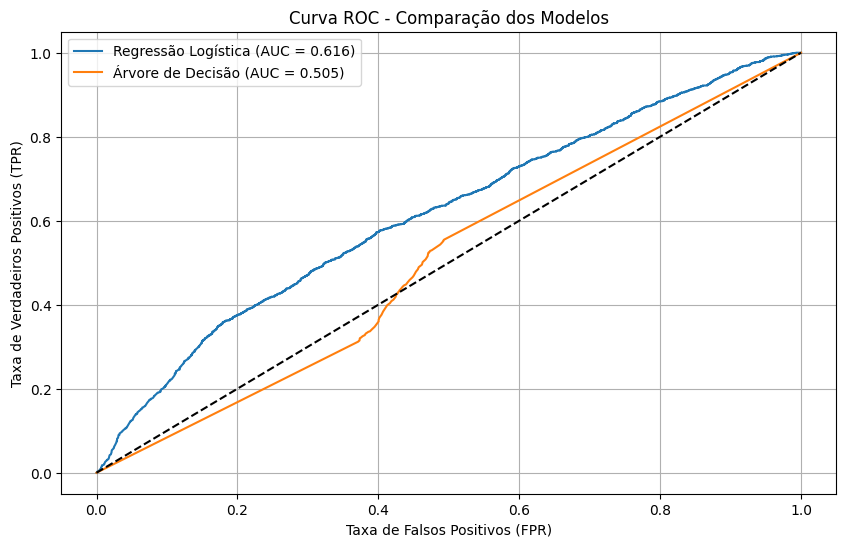


Valores de FPR e TPR para Regressão Logística:
FPR: 0.000, TPR: 0.000
FPR: 0.210, TPR: 0.385
FPR: 0.384, TPR: 0.556
FPR: 0.581, TPR: 0.710
FPR: 0.765, TPR: 0.858
FPR: 0.993, TPR: 1.000

Valores de FPR e TPR para Árvore de Decisão:
FPR: 0.000, TPR: 0.000
FPR: 0.384, TPR: 0.333
FPR: 0.413, TPR: 0.399
FPR: 0.439, TPR: 0.448
FPR: 0.471, TPR: 0.522
FPR: 1.000, TPR: 1.000


In [43]:
# Calcular as probabilidades de predição para cada modelo
y_pred_proba_lr = modelLR.predict_proba(X_test)[:, 1]
y_pred_proba_dtc = modelDTC.predict_proba(X_test)[:, 1]

# Calcular FPR e TPR para cada modelo
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_dtc, tpr_dtc, _ = roc_curve(y_test, y_pred_proba_dtc)

# Calcular AUC para cada modelo
auc_lr = auc(fpr_lr, tpr_lr)
auc_dtc = auc(fpr_dtc, tpr_dtc)

# Criar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Regressão Logística (AUC = {auc_lr:.3f})')
plt.plot(fpr_dtc, tpr_dtc, label=f'Árvore de Decisão (AUC = {auc_dtc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')  # Linha diagonal
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Comparação dos Modelos')
plt.legend()
plt.grid(True)
plt.show()

# Exibir valores de FPR e TPR para alguns pontos
print("\nValores de FPR e TPR para Regressão Logística:")
for i in range(0, len(fpr_lr), len(fpr_lr)//5):
    print(f"FPR: {fpr_lr[i]:.3f}, TPR: {tpr_lr[i]:.3f}")

print("\nValores de FPR e TPR para Árvore de Decisão:")
for i in range(0, len(fpr_dtc), len(fpr_dtc)//5):
    print(f"FPR: {fpr_dtc[i]:.3f}, TPR: {tpr_dtc[i]:.3f}")

# Por: `Eder Martins`

## Obrigado!